# 2-D Daubechies Wavelets

This numerical tour explores 2-D multiresolution analysis 
with Daubchies wavelet transform.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\pa}[1]{\left(#1\right)}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/Users/gpeyre/anaconda/envs/p34/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Wavelets Filters

The 2-D wavelet transform of a continuous image $f(x)$ computes the set
of inner products 
$$ d_j^k[n] = \dotp{f}{\psi_{j,n}^k} $$ 
for scales $ j \in \ZZ $, position $ n \in \ZZ^2 $ and orientation $ k \in \{H,V,D\} $.


The wavelet atoms are defined by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:
$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k \left( \frac{x-2^j n}{2^j} \right)  $$
These oriented wavelets are defined by a tensor product of a 1-D wavelet
function $\psi(t)$ and a 1-D scaling function $\phi(t)$
$$ \psi^H(x)=\phi(x_1)\psi(x_2), \quad  \psi^V(x)=\psi(x_1)\phi(x_2)
\qandq \psi^D(x)=\psi(x_1)\psi(x_2).$$


The fast wavelet transform algorithm does not make use of the wavelet and scaling functions,
but of the filters $h$ and $g$ that caracterize their interaction:
$$ g[n] = \frac{1}{\sqrt{2}}\dotp{\psi(t/2)}{\phi(t-n)} 
\qandq h[n] = \frac{1}{\sqrt{2}}\dotp{\phi(t/2)}{\phi(t-n)}. $$


The simplest filters are the Haar filters
$$ h = [1, 1]/\sqrt{2} \qandq g = [-1, 1]/\sqrt{2}. $$


Daubechies wavelets extends the haar wavelets by using longer
filters, that produce smoother scaling functions and wavelets.
Furthermore, the larger the size $p=2k$ of the filter, the higher is the number
$k$ of vanishing moment. 

A high number of vanishing moments allows to better compress regular
parts of the signal. However, increasing the number of vanishing moments
also inceases the size of the support of the wavelets, wich can be
problematic in part where the signal is singular (for instance
discontinuous).

Choosing the _best_ wavelet, and thus choosing $k$, that is adapted to a
given class of signals, thus corresponds to 
a tradeoff between efficiency in regular and singular parts.

- The filter with $k=1$ vanishing moments corresponds to the Haar filter.
- The filter with $k=2$ vanishing moments corresponds to the famous |D4| wavelet, which compresses perfectly linear signals.
- The filter with $k=3$ vanishing moments compresses perfectly quadratic signals.

Select the low pass filter. We start with the Daubechies 4 filter. Note that the filter should have odd 
length, so we zero-padd it.

In [2]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551] 
h = h/norm(h)

Note that the high pass filter $g$ is computed directly from the low pass filter as:
$$ g[n] = (-1)^{1-n}h[1-n]. $$

In [3]:
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))

In [4]:
print(h)
print(g)

[ 0.          0.48296291  0.8365163   0.22414387 -0.12940952]
[ 0.          0.12940952  0.22414387 -0.8365163   0.48296291]


## Up and Down Filtering

The basic wavelet operation is low/high filtering, followed by down sampling. 

Starting from some 1-D signal $f \in \RR^N$, one thus compute the
low pass signal $a \in \RR^{N/2}$ and the high pass 
signal $d \in \RR^{N/2}$ as
$$ a = (f \star h) \downarrow 2 \qandq 
d = (f \star g) \downarrow 2$$
where the sub-sampling is defined as 
$$ (u \downarrow 2)[k] = u[2k]. $$

Create a random signal $f \in \RR^N$.

In [5]:
N = 256
f = rand(N,1)

Low/High pass filtering followed by sub-sampling.

In [6]:
a = subsampling( cconv(f,h,1),1 )
d = subsampling( cconv(f,g,1),1 )

For orthogonal filters, the reverse of this process is its dual
(aka its transpose), which is upsampling followed by low/high pass
filtering with the reversed filters and summing:
$$ (a \uparrow h) \star \tilde h + (d \uparrow g) \star \tilde g = f $$
where $\tilde h[n]=h[-n]$ (computed modulo $N$) and 
$ (u \uparrow 2)[2n]=u[n] $ and  $ (u \uparrow 2)[2n+1]=0 $.

Perform the up-sampling followed by filtering.

In [7]:
f1 =  cconv(upsampling(a,1),reverse(h),1) + cconv(upsampling(d,1),reverse(g),1)

Check that we really recover the same signal.

In [8]:
print( norm(f-f1)/norm(f) )

5.469343188183937e-13


## Forward 2-D Wavelet transform

The set of wavelet coefficients are computed with a fast algorithm that
exploits the embedding of the approximation spaces $V_j$ spanned by the 
scaling function $ \{ \phi_{j,n} \}_n $ defined as
$$ \phi_{j,n}(x) = \frac{1}{2^j}\phi^0\pa{\frac{x-2^j n}{2^j}} 
\qwhereq \phi^0(x)=\phi(x_1)\phi(x_2). $$

The wavelet transform of $f$ is computed by using intermediate discretized low
resolution images obtained by projection on the spaces $V_j$:
$$ a_j[n] = \dotp{f}{\phi_{j,n}}. $$

Load a gray-scale image $f$ of $n \times n$ pixels. 

In [27]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)

/Users/gpeyre/anaconda/envs/p34/lib/python3.4/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Display the image $f$.

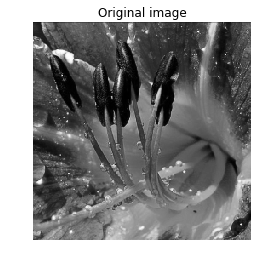

In [28]:
imageplot(f, 'Original image')

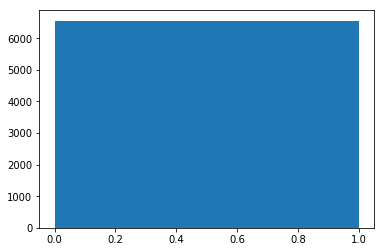

In [44]:
f0 = f
f1 = f.flatten()
f1[ argsort(f0.flatten()) ] = np.linspace(0,1,n*n)
hist(f1.flatten())
I = argsort(f0.flatten())

The algorithm starts at the coarsest scale $ j=\log_2(n)-1 $

In [11]:
j = int(log2(n)-1)

The first step of the algorithm perform filtering/downsampling in the
horizontal direction.

$$ \tilde a_{j-1} = (a_j \star^H h) \downarrow^{2,H}  \qandq 
   \tilde d_{j-1} = (a_j \star^H g) \downarrow^{2,H}$$

Here, the operator $\star^H$ and $\downarrow^{2,H}$
are defined by applying $\star$ and $\downarrow^2$
to each column of the matrix.

The second step computes the filtering/downsampling in the vertical
direction.

$$ a_{j-1}   = (\tilde a_j \star^V h) \downarrow^{2,V}  \qandq 
   d_{j-1}^V = (\tilde a_j \star^V g) \downarrow^{2,V},$$
$$ d_{j-1}^H = (\tilde d_j \star^V h) \downarrow^{2,V}  \qandq 
   d_{j-1}^D = (\tilde d_j \star^V g) \downarrow^{2,V}.$$
    
A wavelet transform is
computed by iterating high pass and loss pass filterings with |h| and |g|, followed by sub-samplings.
Since we are in 2-D, we need to compute these filterings+subsamplings
in the horizontal and then in the vertical direction (or
in the reverse order, it does not mind).

Initialize the transformed coefficients as the image itself and set the
initial scale as the maximum one.
fW will be iteratively transformated and will contains the
coefficients.

In [12]:
fW = f.copy()

Select the sub-part of the image to transform.

In [13]:
A = fW[:2**(j+1):,:2**(j+1):]

Apply high and low filtering+subsampling in the vertical direction (1st ooordinate),
to get coarse and details.

In [14]:
Coarse = subsampling(cconv(A,h,1),1)
Detail = subsampling(cconv(A,g,1),1)

Concatenate them in the vertical direction to get the result.

In [15]:
A = concatenate( (Coarse, Detail), axis=0 )

Display the result of the vertical transform.

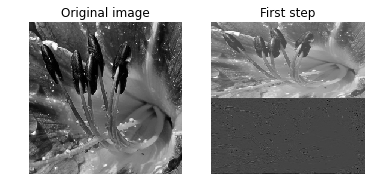

In [16]:
imageplot(f, 'Original image', [1,2,1])
imageplot(A, 'First step', [1,2,2])

Apply high and low filtering+subsampling in the horizontal direction (2nd ooordinate),
to get coarse and details.

In [17]:
Coarse = subsampling(cconv(A,h,2),2)
Detail = subsampling(cconv(A,g,2),2)

Concatenate them in the horizontal direction to get the result.

In [18]:
A = concatenate( (Coarse, Detail), axis=1 )

Assign the transformed data.

In [19]:
fW[:2**(j+1):,:2**(j+1):] = A

Display the result of the horizontal transform.

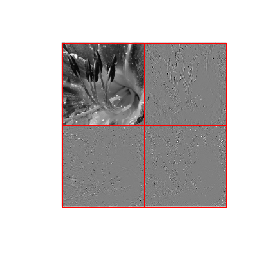

In [20]:
plot_wavelet(fW,j);

Implement a full wavelet transform that extract iteratively wavelet
coefficients, by repeating these steps. Take care of choosing the
correct number of steps.

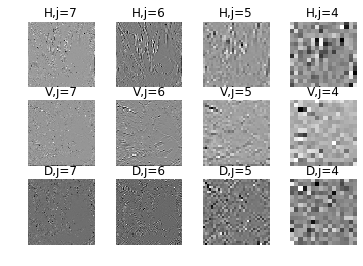

In [21]:
Jmin = 0
Jmax = log2(n)-1
fW = f.copy()
for j in arange(Jmax,Jmin-1,-1):
    A = fW[:2**(j+1):,:2**(j+1):]
    for d in arange(1,3):
        Coarse = subsampling(cconv(A,h,d),d)
        Detail = subsampling(cconv(A,g,d),d)
        A = concatenate( (Coarse, Detail), axis=d-1 )
    fW[:2**(j+1):,:2**(j+1):] = A
    j1 = Jmax-j
    if j1<4:
        subplot(3,4, j1 + 1)
        imageplot(A[:2**j:,2**j:2**(j+1):], 'H,j=' + str(int(j)) )
        subplot(3,4, j1 + 5)
        imageplot(A[2**j:2**(j+1):,:2**j:], 'V,j=' + str(int(j)) )
        subplot(3,4, j1 + 9)
        imageplot(A[2**j:2**(j+1):,2**j:2**(j+1):], 'D,j=' + str(int(j)))

Check for orthogonality of the transform (conservation of energy).

In [22]:
print( 'Energy of the signal/coefficients = ' + str(norm(f)/norm(fW)) )

Energy of the signal/coefficients = 0.999999999996


Display the wavelet coefficients.

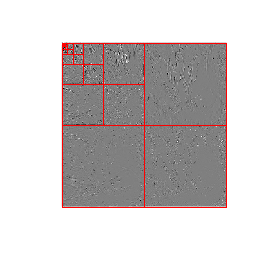

In [23]:
plot_wavelet(fW,Jmin);

## Inverse 2-D Wavelet transform

Inversing the wavelet transform means retrieving a signal `f1` from the
coefficients `fW`. If `fW` are exactely the coefficients of `f`, then
`f=f1` up to machine precision. 

Initialize the image to recover `f1` as the transformed coefficient, and
select the smallest possible scale.

In [24]:
f1 = fW.copy()
j = 0

Select the sub-coefficient to transform.

In [25]:
A = f1[:2**(j+1):,:2**(j+1):]

Retrieve coarse and detail coefficients in the vertical direction (you
can begin by the other direction, this has no importance).

In [26]:
Coarse = A[:2**j:,:]
Detail = A[2**j:2**(j+1):,:]

Undo the transform by up-sampling and then dual filtering.

In [27]:
Coarse = cconv(upsampling(Coarse,1),reverse(h),1)
Detail = cconv(upsampling(Detail,1),reverse(g),1)

Recover the coefficient by summing.

In [28]:
A = Coarse + Detail

Retrieve coarse and detail coefficients in the vertical direction (you
can begin by the other direction, this has no importance).

In [29]:
Coarse = A[:,:2**j:]
Detail = A[:,2**j:2**(j+1):]

Undo the transform by up-sampling and then dual filtering.

In [30]:
Coarse = cconv(upsampling(Coarse,2),reverse(h),2)
Detail = cconv(upsampling(Detail,2),reverse(g),2)

Recover the coefficient by summing.

In [31]:
A = Coarse + Detail

Assign the result.

In [32]:
f1[:2**(j+1):,:2**(j+1):] = A

Write the inverse wavelet transform that computes `f1` from the
coefficients `fW`. Compare `f1` with `f`.

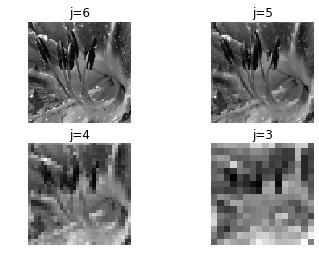

In [33]:
f1 = fW.copy()
for j in arange(Jmin,Jmax+1): 
    A = f1[:2**(j+1):,:2**(j+1):]
    for d in arange(1,3):
        if d==1:
            Coarse = A[:2**j:,:]
            Detail = A[2**j:2**(j+1):,:]
        else:
            Coarse = A[:,:2**j:]
            Detail = A[:,2**j:2**(j+1):]
        Coarse = cconv(upsampling(Coarse,d),reverse(h),d)
        Detail = cconv(upsampling(Detail,d),reverse(g),d)
        A = Coarse + Detail
        j1 = Jmax-j
        if j1>0 and j1<5:
            imageplot(A, 'j=' + str(int(j)), [2,2,j1])
    f1[:2**(j+1):,:2**(j+1):] = A

Check that we recover exactly the original image.

In [35]:
print( 'Error |f-f1|/|f| = ' + str(norm(f-f1)/norm(f)) )

Error |f-f1|/|f| = 8.52769256341e-12


## Linear 2-D Wavelet Approximation

Linear approximation is performed by setting to zero the fine scale wawelets coefficients
and then performing the inverse wavelet transform.

Here we keep only 1/16 of the wavelet coefficient, thus calculating an $m$
term approximation with $m=n^2/16$.

In [36]:
fW = perform_wavortho_transf(f,Jmin,+1,h)
eta = 4
fWLin = zeros((n,n))
fWLin[:n/eta:,:n/eta:] = fW[:n/eta:,:n/eta:]
fLin = perform_wavortho_transf(fWLin,Jmin,-1,h)

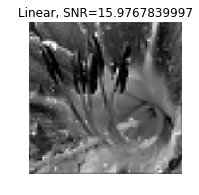

In [37]:
elin = snr(f,fLin)
imageplot(clamp(fLin), 'Linear, SNR=' + str(elin), [1,2,2] )

## Non-Linear 2-D Wavelet Approximation

A non-linear $m$-term approximation is obtained by keeping only the $m$
largest coefficients, which creates the smallest possible error.


Removing the smallest coefficient, to keep the $m$-largest, is
equivalently obtainedby thresholding the coefficients to
set to 0 the smallest coefficients. 


First select a threshold value (the largest the threshold, the more
agressive the approximation).

In [38]:
T = .2

Then set to 0 coefficients with magnitude below the threshold.

In [39]:
fWT = fW * (abs(fW)>T)

Display thresholded coefficients.

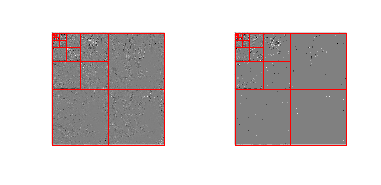

In [40]:
subplot(1,2,1)
plot_wavelet(fW,Jmin);
subplot(1,2,2)
plot_wavelet(fWT,Jmin);

Plot the (log of) the coefficient in decaying order.

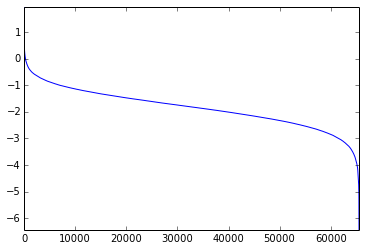

In [41]:
m = round((n**2)/(eta**2))
v = reverse( msort(abs(fW).ravel()) )
plot(log10(v))
axis('tight');

Find the thresholds $T$ so that the number $m$ of remaining coefficients in the threshold coefficients
are $m=n^2/16$. 

In [42]:
T = v[m]

Display the corresponding non-linear approximation.

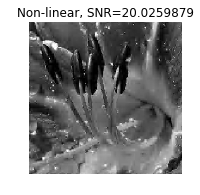

In [43]:
fWT = fW * (abs(fW)>=T)
fnl = perform_wavortho_transf(fWT,Jmin,-1,h)
enl = snr(f,fnl)
imageplot(clamp(fnl), 'Non-linear, SNR=' + str(enl), [1,2,2] )

## Exercise

*Exercise 1:* Compare the approximation obtained using wavelet with different number of vanishing moments.

*Exercise 2:* Implement a 2-D separable wavelet transform.

*Exercise 3:* Display a 2-D wavelet by applying the backward transform to a Dirac (i.e. all zeros excepted a single 1 at a well-chosen position).